## Paso −1. Qué necesitamos, qué entrega HITRAN y qué calculamos

### A. Necesitamos
1) Malla espectral en número de onda:
   - `wave_vector` en cm⁻¹ (rango de interés).

2) Condiciones termodinámicas y geométricas:
   - Temperatura: `T` (K).
   - Presiones parciales: `Pmol` (gas de interés) y `Pair` (aire), presión total `p = Pmol + Pair`.
   - Longitud de trayecto: `L` (m en el código; se convierte a cm al formar la columna).
   - Masa molecular o peso molecular efectivo del gas: `Wg` (para Doppler).

3) Datos auxiliares:
   - Tabla de función de partición: `Q(T)` (archivo TIPS) para evaluar $Q(T_0)$ y $Q(T)$.
   - Constantes físicas: $T_0=296\,$K, $c$, $k_B$, $c_2=\tfrac{hc}{k}$, $N_\ell$ (número de Loschmidt a 1 atm y $T_0$).

### B. HITRAN nos da (por cada línea dentro del rango)
- Centro de línea: $\nu_0$ (cm⁻¹).
- Intensidad tabulada a $T_0$: $S(T_0)$.
- Energía de estado inferior: $E''$ (cm⁻¹).
- Ancho a media altura por aire (1 atm, $T_0$): $\alpha_{a,0}$.
- Ancho a media altura por “self”: $\alpha_{s,0}$.
- Exponente de temperatura para el ancho: $n$.
- Desplazamiento de línea inducido por presión: $\delta$.
- Coeficiente de Einstein $A$ (opcional en este flujo).
- Identificadores de molécula e isotopólogo (para seleccionar especie/iso).

Estas cantidades alimentan directamente:
- La posición efectiva de la línea con presión: $\nu_c=\nu_0+\delta\,p$ (se usa dentro del perfil).
- El reescalado de intensidad $S(T)$ a la temperatura de trabajo (ver más abajo).
- El cálculo del ancho Lorentziano $\gamma(P,T)$ (a partir de $\alpha_{a,0}, \alpha_{s,0}, n$).
- La construcción del perfil de línea $f(\nu-\nu_c)$ (Voigt).

### C. Lo que calculamos (y con qué ecuación/sección del libro)
1) Transmitancia espectral desde la atenuación radiativa:
   $$
   L_\nu(r_2)=L_\nu(r_1)\exp\!\left(-\int_{r_1}^{r_2}k_e(r,\nu)\,dr\right)
   $$
   Sección 2.8.1 – (2.168).

   Definimos profundidad óptica:
   $$
   \tau_r(r_1,r_2)=\int_{r_1}^{r_2}k_e(r,\nu)\,dr
   $$
   Sección 2.8.1 – (2.169).

   En medio homogéneo:
   $$
   T_\nu=\frac{L_\nu(r)}{L_\nu(0)}=e^{-\tau(\nu)}=e^{-k_e(\nu)\,L}
   $$
   Sección 2.8.1 – (2.171).

2) Coeficiente de absorción por línea (base teórica):
   $$
   k_a(\nu)=S\,f(\nu-\nu_0)
   $$
   Sección 2.6 – (2.112).

   Extensión multi–línea usada en el código (suma sobre $i$):
   $$
   k(\nu)=\sum_i S_i(T)\,f_i(\nu-\nu_i, P, T)
   $$
   (No literal; se obtiene sumando contribuciones independientes de (2.112).)

3) Reescalado de $S(T_0)\to S(T)$:
   $$
   S=\frac{h\nu_0}{c}\,B_{12}\,n_1
   $$
   Sección 2.8.3 – (2.178).

   Con Boltzmann para $n_1(T)$ y corrección de emisión estimulada, resulta la forma estándar de HITRAN:
   $$
   S(T)=S(T_0)\frac{Q(T_0)}{Q(T)}\exp\!\Big[-c_2E''\Big(\tfrac{1}{T}-\tfrac{1}{T_0}\Big)\Big]\,
   \frac{1-e^{-c_2\nu_0/T}}{1-e^{-c_2\nu_0/T_0}}
   $$
   (No literal; se deriva a partir de (2.178) y la estadística de Boltzmann.)

4) Ancho Lorentziano por colisiones (ajuste de presión y temperatura):
   $$
   \alpha_0=\alpha_s\,p_i+\alpha_a\,(p_a-p_i)
   $$
   Sección 2.6.2 – (2.126).

   Con el exponente $n$ tabulado se aplica el factor $(T_0/T)^n$ (dependencia de temperatura de $\gamma$ empleada en el código).

5) Perfil de línea: Voigt como convolución de Gauss y Lorentz:
   $$
   (f_C* f_D)(x)=\int_{-\infty}^{+\infty} f_C(y)\,f_D(x-y)\,dy
   $$
   Sección 2.6.3 – (2.127).

   Forma integral equivalente del Voigt:
   $$
   f_V(\nu-\nu_0)=\frac{\alpha_C}{\sqrt{2\pi}\,\sigma^3}\int_{-\infty}^{+\infty}
   \frac{e^{-y^2}}{(x-y)^2+\left(\frac{\alpha_C}{\sqrt{2}\sigma}\right)^2}\,dy
   $$
   Sección 2.6.3 – (2.129).

   Implementación práctica con Faddeeva (no literal): se usan
   $x=\sqrt{\ln 2}\,\frac{\nu-\nu_c}{\alpha_D}$, $y=\sqrt{\ln 2}\,\frac{\gamma}{\alpha_D}$ y
   $$
   f_V(\nu-\nu_c)=\frac{\sqrt{\ln 2}}{\sqrt{\pi}\,\alpha_D}\Re\{w(x+iy)\}
   $$
   (Equivalente a (2.129) al expresar la Gaussiana por su FWHM; el factor $\sqrt{\ln 2}$ proviene de $\mathrm{FWHM}_G=2\sqrt{2\ln 2}\,\sigma$.) (No sé bien esta parte)

6) Densidad numérica y columna:
   - Relación coeficientes–secciones eficaces por especie:
     $$
     k_a=\sum_i n_i\,\sigma_{a,i},\quad
     k_s=\sum_i n_i\,\sigma_{s,i},\quad
     k_e=\sum_i n_i\,\sigma_{e,i}
     $$
     Sección 2.7 – (2.141)–(2.143).

   - Gas ideal para $n_i$:
     
     $$
     n_i=\frac{x_i\,P}{k_B T}
     $$
     (No literal; se usa con (2.141)–(2.143) para pasar de fracciones molares a coeficientes.)

   - Columna para cada línea: $n_iL$ (se agrupa con $S_i(T)$ en el vector que multiplica al perfil $f_{V,i}$ al construir $\tau(\nu)$).

7) Profundidad óptica y transmitancia final:
   - Profundidad óptica homogénea: $\tau(\nu)=k_e(\nu)L$ a partir de (2.169)–(2.171).    
   - Transmitancia: $T_\nu=e^{-k_e(\nu)L}$; si la dispersión es despreciable, $Tr(\nu)=e^{-k(\nu)L}$ (con $k(\nu)$ de la suma de líneas).


In [ ]:
import re, io, os, urllib.request
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz

# ---------- Constantes ----------
p_ref = 1
temp_ref = 296.0       # (T0) K

kerg    = 1.380649e-16 # Boltzmann [erg/K]
c       = 299792458.0  # velocidad de la luz [m/s]
ccm     = c*100.0      # [cm/s]
c2      = 1.43880285   # (hc/k) [cm·K]
Na      = 6.02214086e23
Nl      = temp_ref / (kerg * p_ref)
B       = 1.0 # Ahora le pregunto a manuel
Bt      = 1.0

# ---------- Tabla qN.txt por molécula ----------
MOL_NAME_TO_ID = {"H2O":1,"CO2":2,"O3":3,"N2O":4,"CO":5,"CH4":6,"O2":7}
QFILE_BY_MOLID = {1:1, 2:7, 3:16, 4:21, 5:26, 6:32, 7:36}
ID_TO_MOL_NAME = {v:k for k,v in MOL_NAME_TO_ID.items()}

Descarga automaticamente el qN.txt que se necesite, tambien busca el Wg

In [ ]:
def _get(url:str)->str:
    with urllib.request.urlopen(url) as r:
        return r.read().decode("utf-8", errors="ignore")

# ---------- Q(T) desde qN.txt ----------
def load_Q_from_web(mol_id:int):
    qn = QFILE_BY_MOLID[mol_id]
    txt = _get(f"https://hitran.org/data/Q/q{qn}.txt")
    T, Q = [], []
    for ln in txt.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        p = re.split(r"\s+", ln)
        if len(p) >= 2:
            T.append(float(p[0])); Q.append(float(p[1]))
    T = np.array(T); Q = np.array(Q)
    idx = np.argsort(T)
    return T[idx], Q[idx]

def Q_ratio_from_web(mol_id:int, T_req:float):
    Ttab, Qtab = load_Q_from_web(mol_id)
    T_req_r = float(np.round(T_req))
    # Q(296)
    Q296 = np.interp(temp_ref, Ttab, Qtab)
    QT   = np.interp(T_req_r, Ttab, Qtab)
    return float(Q296/QT)

# ---------- molparam.txt para Wg del isotopólogo ----------
def get_Wg_from_molparam(mol_id:int, iso_id:int)->float:
    txt = _get("https://hitran.org/media/molparam.txt")
    cur_mol = None
    cur_id  = None
    iso_ord = 0
    for ln in txt.splitlines():
        m0 = re.match(r"^\s*([A-Za-z0-9_]+)\s*\((\d+)\)\s*$", ln)
        if m0:
            cur_mol = m0.group(1)
            cur_id  = int(m0.group(2))
            iso_ord = 0
            continue
        m = re.match(r"^\s*(\d{3})\s+([0-9.E+\-]+)\s+([0-9.E+\-]+)\s+(\d+)\s+([0-9.E+\-]+)", ln)
        if m and cur_id == mol_id:
            iso_ord += 1
            if iso_ord == iso_id:
                Wg = float(m.group(5))  # molar mass (g/mol)
                return Wg
    raise ValueError("No encontré Wg en molparam para esa molécula/isotopólogo.")

Lectura del .par

In [ ]:
def read_par_subset(par_path, vmin, vmax, mol_id, iso_id):
    with open(par_path, "r", encoding="utf-8", errors="ignore") as f:
        header = f.readline()
        if ("\t" in header) and ("Molecule" in header or "Isotopologue" in header or "ν" in header or "nu" in header):
            cols = [c.strip() for c in header.strip().split("\t")]
            idx = {n:i for i,n in enumerate(cols)}
            def col(*names):
                for n in names:
                    if n in idx: return idx[n]
                return None
            c_mid = col("Molecule ID","MoleculeID","Molecule")
            c_iso = col("Isotopologue ID","IsotopologueID","Iso")
            c_nu  = col("ν","nu","wavenumber")
            c_S0  = col("S","S0")
            c_gair= col("γair","gamma_air")
            c_gself=col("γself","gamma_self")
            c_nair= col("nair","n_air")
            c_dair= col("δair","delta_air","delta")
            c_El  = col('E"',"El","E_lower")

            nu_c, S0_c, ga, gs, EL, na, da = [],[],[],[],[],[],[]
            with open(par_path, "r", encoding="utf-8", errors="ignore") as f2:
                next(f2)  # salta header
                for ln in f2:
                    parts = ln.rstrip("\n").split("\t")
                    try:
                        mid = int(parts[c_mid]); iso = int(parts[c_iso]); nu = float(parts[c_nu])
                    except:
                        continue
                    if mid != mol_id or (iso_id is not None and iso != iso_id):
                        continue
                    if nu < vmin or nu > vmax:
                        continue
                    nu_c.append(nu)
                    S0_c.append(float(parts[c_S0]))
                    ga.append(float(parts[c_gair]))
                    gs.append(float(parts[c_gself]))
                    EL.append(float(parts[c_El]))
                    na.append(float(parts[c_nair]))
                    da.append(float(parts[c_dair]))
            return { "nu":np.array(nu_c), "S0":np.array(S0_c),
                     "gamma_air":np.array(ga), "gamma_self":np.array(gs),
                     "E_lower":np.array(EL), "n_air":np.array(na), "delta_air":np.array(da) } # Revisar esto

    # Formato fijo 160c
    def _safe_float(s):
        s = s.strip().replace("D","E")
        return float(s) if s else np.nan

    nu_c, S0_c, ga, gs, EL, na, da = [],[],[],[],[],[],[]
    with open(par_path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            try:
                mid = int(ln[0:2]); iso = int(ln[2:3])
                if mid != mol_id or (iso_id is not None and iso != iso_id):
                    continue
                nu = _safe_float(ln[3:15])
                if nu < vmin or nu > vmax:
                    continue
                S0     = _safe_float(ln[15:25])
                g_air  = _safe_float(ln[35:40])
                g_self = _safe_float(ln[40:45])
                E_lo   = _safe_float(ln[45:55])
                n_air  = _safe_float(ln[55:59])
                d_air  = _safe_float(ln[59:67])
            except Exception:
                continue
            nu_c.append(nu); S0_c.append(S0); ga.append(g_air); gs.append(g_self)
            EL.append(E_lo); na.append(n_air); da.append(d_air)
    return { "nu":np.array(nu_c), "S0":np.array(S0_c),
             "gamma_air":np.array(ga), "gamma_self":np.array(gs),
             "E_lower":np.array(EL), "n_air":np.array(na), "delta_air":np.array(da) }


In [ ]:
# Example usage of read_par_subset
par_path = "/content/HITRAN.par"  # Replace with the actual path to your .par file
vmin = 655
vmax = 1000
mol_id = 1  # H2O
iso_id = 1  # main isotopologue of H2O

hitran_data = read_par_subset(par_path, vmin, vmax, mol_id, iso_id)

print("Data returned by read_par_subset:")
for key, value in hitran_data.items():
    print(f"  Key: {key}")
    print(f"  Value: {value}")
    print(f"  Shape: {value.shape}")
    print("-" * 20)

Data returned by read_par_subset:
  Key: nu
  Value: [655.092625 655.259144 655.378727 ... 998.809594 998.886586 999.077449]
  Shape: (1589,)
--------------------
  Key: S0
  Value: [4.806e-30 3.866e-29 1.055e-29 ... 2.175e-24 8.946e-26 3.114e-30]
  Shape: (1589,)
--------------------
  Key: gamma_air
  Value: [0.0425 0.0686 0.0423 ... 0.0626 0.0539 0.0718]
  Shape: (1589,)
--------------------
  Key: gamma_self
  Value: [0.333 0.333 0.333 ... 0.319 0.235 0.315]
  Shape: (1589,)
--------------------
  Key: E_lower
  Value: [4775.0882  882.8903 4774.8049 ... 1631.383  2880.8342 2225.4692]
  Shape: (1589,)
--------------------
  Key: n_air
  Value: [0.42 0.62 0.42 ... 0.59 0.52 0.72]
  Shape: (1589,)
--------------------
  Key: delta_air
  Value: [-0.01757  0.      -0.01746 ... -0.00556  0.00466  0.00017]
  Shape: (1589,)
--------------------


In [ ]:
# ---------- Voigt ----------
def voigt_profile(wnu, nu0, alphaD, gammaL):
    x = np.sqrt(np.log(2.0)) * (wnu[:,None] - nu0[None,:]) / alphaD[None,:]
    y = np.sqrt(np.log(2.0)) *  gammaL[None,:]             / alphaD[None,:]
    z = x + 1j*y
    w = wofz(z)
    return np.sqrt(np.log(2.0))/np.sqrt(np.pi) * np.real(w) / alphaD[None,:]

In [ ]:
def generate_HITRAN_spectrum_test_batched(
    wave_vector, par_path, mol, iso_id, temp, Pmol, Pair, L,
    do_plot=True, plot_in_um=True,
    batch_size_pts=5000,
    pad_cm1=2.0
):
    mol_id = mol if isinstance(mol,int) else MOL_NAME_TO_ID[mol.upper()]
    pres = Pmol + Pair
    T = float(np.round(temp))

    # Rango total para lectura del .par (solo una vez)
    vmin, vmax = float(np.min(wave_vector)), float(np.max(wave_vector))
    H = read_par_subset(par_path, vmin, vmax, mol_id, iso_id)
    nu0   = H["nu"]; S0 = H["S0"]; g_air=H["gamma_air"]; g_self=H["gamma_self"]
    E_lo  = H["E_lower"]; n_air=H["n_air"]; d_air=H["delta_air"]

    if nu0.size == 0:
        Tr = np.ones_like(wave_vector, float)
        if do_plot:
            x = (1e4/wave_vector) if plot_in_um else wave_vector
            plt.figure(figsize=(7,3))
            plt.plot(x, Tr, lw=1)
            plt.xlabel("Wavelength (μm)" if plot_in_um else "Wavenumber (cm$^{-1}$)")
            plt.ylabel("Transmittance")
            plt.gca().invert_xaxis()
            plt.grid(True, alpha=.3); plt.margins(0); plt.tight_layout(pad=0); plt.show()
        return Tr

    # Q(296)/Q(T) y Wg (una sola vez)
    Qratio = Q_ratio_from_web(mol_id, T)
    Wg = get_Wg_from_molparam(mol_id, iso_id)

    nu_c = nu0 + d_air*pres
    S_T = S0 * Qratio * np.exp(-c2*E_lo/T)/np.exp(-c2*E_lo/temp_ref) \
            * (1.0 - np.exp(-c2*nu0/T)) / (1.0 - np.exp(-c2*nu0/temp_ref))
    L_cm = L*100.0
    I_line = S_T * (B/Bt) * (temp_ref/T) * Nl * Pmol * L_cm
    alphaD = nu0/ccm * np.sqrt(2.0*Na*kerg*T*np.log(2.0)/Wg)
    gammaL = ((temp_ref/T)**n_air) * (g_air*(pres - Pmol) + g_self*Pmol)

    tau_full = np.zeros_like(wave_vector, dtype=float)

    N = wave_vector.size
    for i0 in range(0, N, batch_size_pts):
        i1 = min(i0 + batch_size_pts, N)
        w_block = wave_vector[i0:i1]
        wmin, wmax = float(w_block.min()), float(w_block.max())
        print("batch", i0/batch_size_pts, "/", N/batch_size_pts)

        sel = (nu_c >= wmin - pad_cm1) & (nu_c <= wmax + pad_cm1)
        if not np.any(sel):
            continue

        nu_c_sub = nu_c[sel]
        I_sub    = I_line[sel]
        aD_sub   = alphaD[sel]
        gL_sub   = gammaL[sel]

        fV = voigt_profile(w_block.astype(float), nu_c_sub, aD_sub, gL_sub)  # [nblock x nlines_sub]
        tau_full[i0:i1] += fV @ I_sub

    Tr = np.exp(-tau_full)

    if do_plot:
        x = (1e4/wave_vector) if plot_in_um else wave_vector
        plt.figure(figsize=(7,3))
        plt.plot(x, Tr, lw=1)
        plt.xlabel("Wavelength (μm)" if plot_in_um else "Wavenumber (cm$^{-1}$)")
        plt.ylabel("Transmittance")
        plt.title(f"{ID_TO_MOL_NAME[mol_id]} iso {iso_id} — {T:.0f} K, {Pmol} atm, L={L} m")
        plt.grid(True, alpha=.3)
        plt.margins(0)
        plt.tight_layout(pad=0)
        plt.show()

    return Tr

In [ ]:
PAR_PATH = "/content/HITRAN.par"
wave = np.arange(655, 10000, 0.001)
Tr = generate_HITRAN_spectrum_test_batched(
    wave_vector=wave,
    par_path=PAR_PATH,
    mol="H2O",
    iso_id=1,
    temp=300.0,   # K
    Pmol=0.1,  # atm
    Pair=0,
    L=0.1,        # m
    do_plot=True,
    plot_in_um=True
)

batch 0.0 / 1869.0
batch 1.0 / 1869.0
batch 2.0 / 1869.0
batch 3.0 / 1869.0
batch 4.0 / 1869.0
batch 5.0 / 1869.0
batch 6.0 / 1869.0
batch 7.0 / 1869.0
batch 8.0 / 1869.0
batch 9.0 / 1869.0
batch 10.0 / 1869.0
batch 11.0 / 1869.0
batch 12.0 / 1869.0
batch 13.0 / 1869.0
batch 14.0 / 1869.0
batch 15.0 / 1869.0
batch 16.0 / 1869.0
batch 17.0 / 1869.0
batch 18.0 / 1869.0
batch 19.0 / 1869.0
batch 20.0 / 1869.0
batch 21.0 / 1869.0
batch 22.0 / 1869.0
batch 23.0 / 1869.0
batch 24.0 / 1869.0
batch 25.0 / 1869.0
batch 26.0 / 1869.0
batch 27.0 / 1869.0
batch 28.0 / 1869.0
batch 29.0 / 1869.0
batch 30.0 / 1869.0
batch 31.0 / 1869.0
batch 32.0 / 1869.0
batch 33.0 / 1869.0
batch 34.0 / 1869.0
batch 35.0 / 1869.0
batch 36.0 / 1869.0
batch 37.0 / 1869.0
batch 38.0 / 1869.0
batch 39.0 / 1869.0
batch 40.0 / 1869.0
batch 41.0 / 1869.0
batch 42.0 / 1869.0
batch 43.0 / 1869.0
batch 44.0 / 1869.0
batch 45.0 / 1869.0
batch 46.0 / 1869.0
batch 47.0 / 1869.0
batch 48.0 / 1869.0
batch 49.0 / 1869.0
batch 50.0

KeyboardInterrupt: 

batch 0.0 / 200.0
batch 1.0 / 200.0
batch 2.0 / 200.0
batch 3.0 / 200.0
batch 4.0 / 200.0
batch 5.0 / 200.0
batch 6.0 / 200.0
batch 7.0 / 200.0
batch 8.0 / 200.0
batch 9.0 / 200.0
batch 10.0 / 200.0
batch 11.0 / 200.0
batch 12.0 / 200.0
batch 13.0 / 200.0
batch 14.0 / 200.0
batch 15.0 / 200.0
batch 16.0 / 200.0
batch 17.0 / 200.0
batch 18.0 / 200.0
batch 19.0 / 200.0
batch 20.0 / 200.0
batch 21.0 / 200.0
batch 22.0 / 200.0
batch 23.0 / 200.0
batch 24.0 / 200.0
batch 25.0 / 200.0
batch 26.0 / 200.0
batch 27.0 / 200.0
batch 28.0 / 200.0
batch 29.0 / 200.0
batch 30.0 / 200.0
batch 31.0 / 200.0
batch 32.0 / 200.0
batch 33.0 / 200.0
batch 34.0 / 200.0
batch 35.0 / 200.0
batch 36.0 / 200.0
batch 37.0 / 200.0
batch 38.0 / 200.0
batch 39.0 / 200.0
batch 40.0 / 200.0
batch 41.0 / 200.0
batch 42.0 / 200.0
batch 43.0 / 200.0
batch 44.0 / 200.0
batch 45.0 / 200.0
batch 46.0 / 200.0
batch 47.0 / 200.0
batch 48.0 / 200.0
batch 49.0 / 200.0
batch 50.0 / 200.0
batch 51.0 / 200.0
batch 52.0 / 200.0
bat

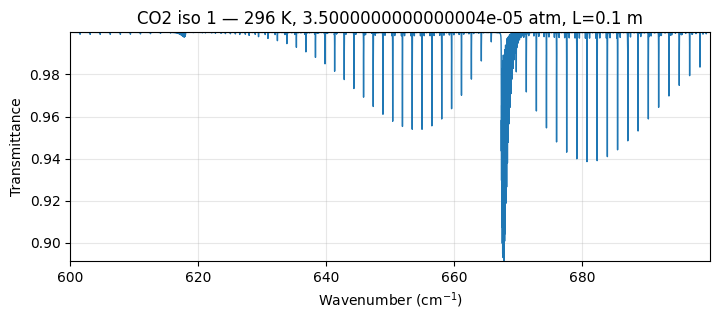

In [ ]:
PAR_PATH = "/content/HITRAN.par"
MOL = "CO2"
ISO_ID = 1
TEMP = 296.0
P_TOTAL = 0.1
X_CO2 = 350e-6
L_PATH = 0.10

Pmol = P_TOTAL * X_CO2
Pair = P_TOTAL - Pmol

wave = np.arange(600, 700, 0.0001)

Tr = generate_HITRAN_spectrum_test_batched(
    wave_vector = wave,
    par_path = PAR_PATH,
    mol = MOL,
    iso_id = ISO_ID,
    temp = TEMP,
    Pmol = Pmol,
    Pair = Pair,
    L = L_PATH,
    do_plot = True,
    plot_in_um = False
)

batch 0.0 / 15.0
batch 1.0 / 15.0
batch 2.0 / 15.0
batch 3.0 / 15.0
batch 4.0 / 15.0
batch 5.0 / 15.0
batch 6.0 / 15.0
batch 7.0 / 15.0
batch 8.0 / 15.0
batch 9.0 / 15.0
batch 10.0 / 15.0
batch 11.0 / 15.0
batch 12.0 / 15.0
batch 13.0 / 15.0
batch 14.0 / 15.0


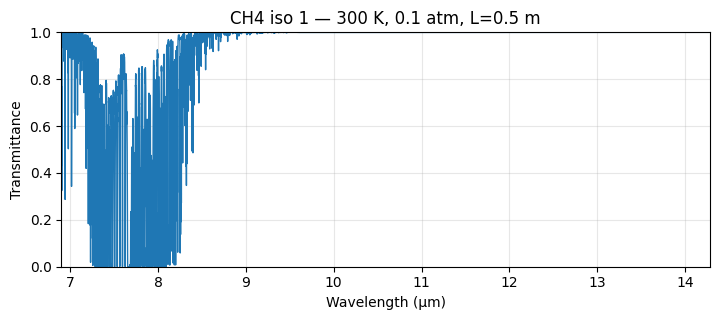

Vector Tr guardado en /content/Tr.npy


In [ ]:
Tr = generate_HITRAN_spectrum_test_batched(
    wave_vector = np.arange(700, 1450, 0.001),
    batch_size_pts=50000,
    par_path="/content/HITRAN.par",
    mol="CH4",
    iso_id=1,
    temp=300.0,
    Pmol=0.1,
    Pair=0.9,
    L=0.5,
    do_plot=True
)

# es para una simulacion de un gas, para gas detection
np.save("/content/Tr.npy", Tr)
print("Vector Tr guardado en /content/Tr.npy")

In [ ]:
wave = np.arange(655, 10000, 0.001)
wave

array([ 655.        ,  655.001     ,  655.002     , ..., 9999.99699978,
       9999.99799978, 9999.99899978])